In [1]:
import os
gemini_key = os.getenv("gemini_api_key")

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import ChatPromptTemplate
from langchain.prompts import HumanMessagePromptTemplate
llm = ChatGoogleGenerativeAI(model= "gemini-2.0-flash", temperature = 0, google_api_key = gemini_key, convert_system_message_to_human=True)

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [4]:
_set_env("LC_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Research-Agent"

In [5]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affliation of the analyst."
    )
    name: str= Field(
        description="Name of the analyst(Name of the human who is analyst)."
    )
    role: str= Field(
        description="Role of the analyst in the context of the topic."
    )
    description:str = Field(
        description="Description of the analyst focus, concern and motives."
    )
    
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    
class Perspectives(BaseModel):
    analysts: List[Analyst]= Field(
        description="Comprehensive list of analysts with thier roles and affiliation"
    ) 

class GenerateAnalystState(TypedDict):
    topic: str
    max_analyst: str
    human_analyst_feedback: str
    analysts: List[Analyst]

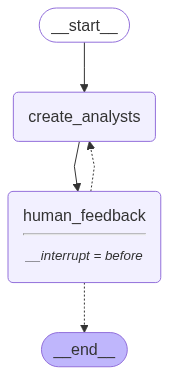

In [10]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage,ChatMessage 

def create_analysts(state: GenerateAnalystState):
    topic= state["topic"]
    max_analysts = state["max_analyst"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")
    analyst_instructions=f"""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

    1. First, review the research topic:
    {topic}
            
    2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
            
    {human_analyst_feedback}
        
    3. Determine the most interesting themes based upon documents and / or feedback above.
                        
    4. Pick the top {max_analysts} themes.

    5. Assign one analyst to each theme."""
    
    structured_llm = llm.with_structured_output(Perspectives)
    
    # system_message = analyst_instructions.format(topic = topic, max_analysts = max_analysts, human_analyst_feedback = human_analyst_feedback)
    
    analysts = structured_llm.invoke([analyst_instructions]+[HumanMessage(content="generate the set of analysts.")])
    
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystState):
    
    human_analyst_feedback = state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"
    return END

builder = StateGraph(GenerateAnalystState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

memory = MemorySaver()
graph = builder.compile(interrupt_before = ["human_feedback"], checkpointer = memory)

display(Image(graph.get_graph(xray= 1).draw_mermaid_png()))

In [11]:
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "3"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analyst":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Name: Alice Johnson
Affiliation: Independent AI Consultant
Role: Technology Adoption Strategist
Description: Focuses on the practical applications and efficiency gains of new AI technologies. Concerned with ease of implementation and ROI.
--------------------------------------------------
Name: Bob Williams
Affiliation: Large Language Model Security Firm
Role: AI Security Analyst
Description: Dedicated to identifying and mitigating security vulnerabilities in AI systems. Concerned with potential risks and exploits in LangGraph.
--------------------------------------------------
Name: Dr. Carol Davis
Affiliation: Academic AI Research Lab
Role: AI Research Scientist
Description: Interested in the theoretical advancements and potential research directions enabled by LangGraph. Concerned with the framework's impact on the future of AI.
--------------------------------------------------


In [12]:
# memory.delete_thread(thread["configurable"]["thread_id"])

In [13]:
state = graph.get_state(thread)
state.next

('human_feedback',)

In [14]:
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective."}, as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f032488-116d-6586-8002-d25b6301d2a4'}}

In [16]:
for event in graph.stream(None, thread, stream_mode= "values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Anya Sharma
Affiliation: Large Language Model Company
Role: AI Research Scientist
Description: Believes LangGraph is beneficial for creating structured and reliable agent workflows, especially for complex tasks. Focuses on the framework's ability to improve agent consistency and reduce errors.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Startup
Role: CTO
Description: Sees LangGraph as a potential accelerator for development, allowing the startup to quickly prototype and deploy sophisticated AI agents with limited resources. Concerned about the learning curve and integration challenges with existing infrastructure.
--------------------------------------------------
Name: Kenji Tanaka
Affiliation: Independent AI Consultant
Role: AI Consultant
Description: Interested in LangGraph's flexibility and customizability. Evaluates its suitability for various client needs, focusing on its ability to create tailored agent solutions.  Concerned abo

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Name: Dr. Anya Sharma
Affiliation: Large Language Model Company
Role: AI Research Scientist
Description: Believes LangGraph is beneficial for creating structured and reliable agent workflows, especially for complex tasks. Focuses on the framework's ability to improve agent consistency and reduce errors.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Startup
Role: CTO
Description: Sees LangGraph as a potential accelerator for development, allowing the startup to quickly prototype and deploy sophisticated AI agents with limited resources. Concerned about the learning curve and integration challenges with existing infrastructure.
--------------------------------------------------
Name: Kenji Tanaka
Affiliation: Independent AI Consultant
Role: AI Consultant
Description: Interested in LangGraph's flexibility and customizability. Evaluates its suitability for various client needs, focusing on its ability to create tailored agent solutions.  Concerned abo

In [17]:
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f032488-b9eb-62f3-8006-4811e0ee22b7'}}

In [18]:
for event in graph.stream(None, thread, stream_mode= 'values'):
    print("--Node--")
    print(event.keys())
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
dict_keys(['topic', 'max_analyst', 'human_analyst_feedback', 'analysts'])
topic


In [19]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [20]:
final_state


StateSnapshot(values={'topic': 'The benefits of adopting LangGraph as an agent framework', 'max_analyst': 3, 'human_analyst_feedback': None, 'analysts': [Analyst(affiliation='Large Language Model Company', name='Dr. Anya Sharma', role='AI Research Scientist', description="Believes LangGraph is beneficial for creating structured and reliable agent workflows, especially for complex tasks. Focuses on the framework's ability to improve agent consistency and reduce errors."), Analyst(affiliation='Tech Startup', name='Raj Patel', role='CTO', description='Sees LangGraph as a potential accelerator for development, allowing the startup to quickly prototype and deploy sophisticated AI agents with limited resources. Concerned about the learning curve and integration challenges with existing infrastructure.'), Analyst(affiliation='Independent AI Consultant', name='Kenji Tanaka', role='AI Consultant', description="Interested in LangGraph's flexibility and customizability. Evaluates its suitability 

In [21]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Anya Sharma
Affiliation: Large Language Model Company
Role: AI Research Scientist
Description: Believes LangGraph is beneficial for creating structured and reliable agent workflows, especially for complex tasks. Focuses on the framework's ability to improve agent consistency and reduce errors.
--------------------------------------------------
Name: Raj Patel
Affiliation: Tech Startup
Role: CTO
Description: Sees LangGraph as a potential accelerator for development, allowing the startup to quickly prototype and deploy sophisticated AI agents with limited resources. Concerned about the learning curve and integration challenges with existing infrastructure.
--------------------------------------------------
Name: Kenji Tanaka
Affiliation: Independent AI Consultant
Role: AI Consultant
Description: Interested in LangGraph's flexibility and customizability. Evaluates its suitability for various client needs, focusing on its ability to create tailored agent solutions.  Concerned abo

In [22]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [23]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    
   analyst = state["analyst"]
   messages = state["messages"]
   question_instructions =  f"""You are an analyst tasked with interviewing an expert to learn about a specific topic. 

   Your goal is boil down to interesting and specific insights related to your topic.

   1. Interesting: Insights that people will find surprising or non-obvious.
         
   2. Specific: Insights that avoid generalities and include specific examples from the expert.

   Here is your topic of focus and set of goals: {analyst.persona}
         
   Begin by introducing yourself using a name that fits your persona, and then ask your question.

   Continue to ask questions to drill down and refine your understanding of the topic.
         
   When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

   Remember to stay in character throughout your response, reflecting the persona and goals provided to you.{messages}"""
   print(f"State Message ==> {messages}")
   # Generate question 
   # system_message = question_instructions.format(goals=analyst.persona)
   # print(f"System Message ==> {system_message}")
   # chat_template = ChatPromptTemplate.from_messages(
   # [
   #    SystemMessage(content= system_message)
   # ]+messages
   # )
   # chat_message =  chat_template.format_messages()
   # question = llm.invoke([SystemMessage(content=system_message)]+messages)
   question = llm.invoke([question_instructions])
   print("question ==> ",question)
   # Write messages to state
   return {"messages": [question]}
 

In [28]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

tavily_search = TavilySearchResults(max_results = 3, tavily_api_key = os.getenv("tavily_api_key"))

In [29]:
tavily_search.invoke("what are animals")

"HTTPError('401 Client Error: Unauthorized for url: https://api.tavily.com/search')"

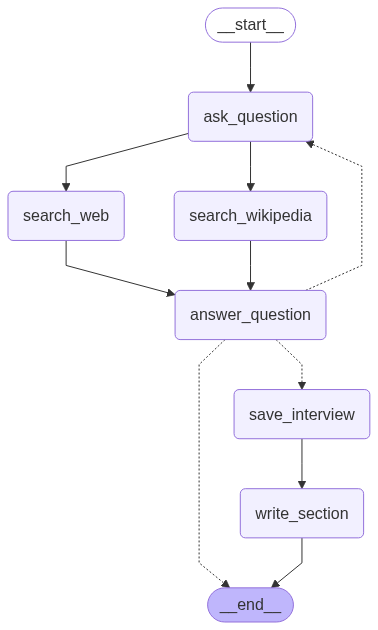

In [26]:
from langchain_core.messages import get_buffer_string

def search_web(state: InterviewState):
    search_instructions = f"""You will be given a conversation between an analyst and an expert. 

    Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
            
    First, analyze the full conversation.

    Pay particular attention to the final question posed by the analyst.

    Convert this final question into a well-structured web search query.
    In the end you have to say done.{state["messages"]}"""
    structured_llm = llm.with_structured_output(SearchQuery)
    # print(f"Messages == > {state["messages"]}")
    search_query = structured_llm.invoke(search_instructions)
    print(f"search Query ==> {search_query}")
    search_docs = tavily_search.invoke(search_query.search_query)
    # print(search_docs)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            # print("Docs ==> ",doc)
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):
    search_instructions = f"""You will be given a conversation between an analyst and an expert. 

    Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
            
    First, analyze the full conversation.

    Pay particular attention to the final question posed by the analyst.

    Convert this final question into a well-structured web search query.
    In the end you have to say done.{state["messages"]}"""
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke(search_instructions)
    print(f"search Query wiki ==> {search_query}")
    search_docs = WikipediaLoader(query = search_query.search_query, load_max_docs=2).load()
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation.
If you don't known the answer just refuse them politely."""

def generate_answer(state: InterviewState):
    
    analyst = state['analyst']
    messages = state['messages']
    context = state['context']
    answer_instructions = f"""You are an expert being interviewed by an analyst.

    Here is analyst area of focus: {analyst.persona}. 
            
    You goal is to answer a question posed by the interviewer.

    To answer question, use this context:
            
    {context}

    When answering questions, follow these guidelines:
            
    1. Use only the information provided in the context. 
            
    2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

    3. The context contain sources at the topic of each individual document.

    4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

    5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
            
    6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
            
    [1] assistant/docs/llama3_1.pdf, page 7 
            
    And skip the addition of the brackets as well as the Document source preamble in your citation.
    If you don't known the answer just refuse them politely.{messages}"""
    print(f"Context ==> {context}")
    answer = llm.invoke(answer_instructions)
    print(f"Answer ==> {answer}")
    answer.name = "Expert"
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, name: str = 'Expert'):
    
    messages = state['messages']
    max_num_turns = state.get('max_num_turns', 2)
    
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    print(f"State Message Again ==> {messages}")
    print(f"num_response ==> {num_responses}")
    if num_responses >= max_num_turns:
        return "save_interview"
    
    last_question = messages[-2]
    
    if "Thank you so much for your help!" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
    """ Node to answer a question """
    section_writer_instructions = f"""You are an expert technical writer. 
            
    Your task is to create a short, easily digestible section of a report based on a set of source documents.

    1. Analyze the content of the source documents: 
    - The name of each source document is at the start of the document, with the <Document tag.
            
    2. Create a report structure using markdown formatting:
    - Use ## for the section title
    - Use ### for sub-section headers
            
    3. Write the report following this structure:
    a. Title (## header)
    b. Summary (### header)
    c. Sources (### header)

    4. Make your title engaging based upon the focus area of the analyst: 
    {analyst.description}

    5. For the summary section:
    - Set up summary with general background / context related to the focus area of the analyst
    - Emphasize what is novel, interesting, or surprising about insights gathered from the interview
    - Create a numbered list of source documents, as you use them
    - Do not mention the names of interviewers or experts
    - Aim for approximately 400 words maximum
    - Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
            
    6. In the Sources section:
    - Include all sources used in your report
    - Provide full links to relevant websites or specific document paths
    - Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
    - It will look like:

    ### Sources
    [1] Link or Document name
    [2] Link or Document name

    7. Be sure to combine sources. For example this is not correct:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
    [4] https://ai.meta.com/blog/meta-llama-3-1/

    There should be no redundant sources. It should simply be:

    [3] https://ai.meta.com/blog/meta-llama-3-1/
            
    8. Final review:
    - Ensure the report follows the required structure
    - Include no preamble before the title of the report
    - Check that all guidelines have been followed"""
    # Get state
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    # system_message = section_writer_instructions.format(focus=analyst.description)
    # section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
    section = llm.invoke([section_writer_instructions]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [27]:
from IPython.display import Markdown

messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
# messages = [{"role": "user", "content": f"So you said you were writing an article on {topic}?"}]
# print(messages[0]['role']['content'])
thread = {"configurable" : {"thread_id" : "8"}}
interview = interview_graph.invoke({"analyst": analysts[2], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview["sections"][0])

State Message ==> [HumanMessage(content='So you said you were writing an article on The benefits of adopting LangGraph as an agent framework?', additional_kwargs={}, response_metadata={}, id='6f8b7f77-aee1-4b60-9de4-272509cb600c')]


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content='Okay, here we go.\n\n"Hello, I\'m Kenji Tanaka, an independent AI consultant. I\'m currently evaluating LangGraph for its potential use in building custom agent solutions for my clients. I understand you\'ve been working with LangGraph. I\'m particularly interested in understanding the *specific* benefits it offers over other agent frameworks, especially in terms of flexibility and customizability. Could you elaborate on some concrete examples where LangGraph\'s graph-based approach truly shines, perhaps in scenarios where traditional sequential agent chains fall short?"' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run-aa541ed1-cd32-4445-bda6-704bef35557b-0' usage_metadata={'input_tokens': 304, 'output_tokens': 111, 'total_tokens': 415, 'input_token_details': {'cache_read': 0}}


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query wiki ==> search_query='LangGraph benefits over other agent frameworks flexibility customizability concrete examples'
search Query ==> search_query='LangGraph benefits over other agent frameworks flexibility customizability concrete examples'
Context ==> ['<Document href="https://oxylabs.io/blog/langgraph-vs-langchain"/>\nSumming up\nLangChain and LangGraph both offer distinct approaches to building agents. LangChain excels in flexibility and scalability, making it ideal for complex applications that require deep integration with large language models. On the other hand, LangGraph is better suited for users looking for a more intuitive, visual approach to designing simpler agent workflows. At the end of the day, choosing between the two will depend on the specific needs of your project. [...] LangGraph\'s visual interface and modular design make it easier to handle complex scenarios, such as multi-step reasoning or managing multiple agents interacting with various data sour

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Answer ==> content="LangGraph offers several benefits over other AI libraries for developers who want to create stateful, multi-actor applications with Large Language Models (LLMs) [2]. LangGraph's expressiveness allows developers to tackle unique, complex tasks without being limited to a single pre-set approach, making it ideal for customized applications and specialized workflows [3]. It is designed to handle complex tasks like keeping track of information, coordinating the order of actions, and letting developers control each agent’s steps precisely [3]. LangGraph's visual interface and modular design make it easier to handle complex scenarios, such as multi-step reasoning or managing multiple agents interacting with various data sources [1]. LangGraph includes built-in moderation and quality control loops, making it easy to keep agents on track and prevent mistakes [3].\n\nLangGraph is particularly useful for developing advanced chatbots that require more flexible and customized in

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


question ==>  content="Thank you for the overview. Kenji Tanaka here again.\n\nThe points about expressiveness and handling complex tasks are helpful, but I'm looking for more *specific* examples. Could you describe a particular use case where LangGraph's graph structure enabled a solution that would have been significantly more difficult or impossible to achieve with a traditional sequential chain? Perhaps a scenario involving dynamic agent collaboration or complex state management? I'm trying to understand the *unique* advantages in practice." additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []} id='run-beac7b18-7530-42f8-969f-0d25b6bbc6e2-0' usage_metadata={'input_tokens': 1059, 'output_tokens': 97, 'total_tokens': 1156, 'input_token_details': {'cache_read': 0}}


d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")
d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


search Query ==> search_query='LangGraph use cases vs sequential agent chains: dynamic agent collaboration and complex state management examples'
search Query wiki ==> search_query='LangGraph use cases vs sequential chains: dynamic agent collaboration, complex state management'
Context ==> ['<Document href="https://oxylabs.io/blog/langgraph-vs-langchain"/>\nSumming up\nLangChain and LangGraph both offer distinct approaches to building agents. LangChain excels in flexibility and scalability, making it ideal for complex applications that require deep integration with large language models. On the other hand, LangGraph is better suited for users looking for a more intuitive, visual approach to designing simpler agent workflows. At the end of the day, choosing between the two will depend on the specific needs of your project. [...] LangGraph\'s visual interface and modular design make it easier to handle complex scenarios, such as multi-step reasoning or managing multiple agents interactin

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


Answer ==> content='LangGraph shines in managing complex workflows that require advanced orchestration and state management [4]. It offers advanced state management with persistent states across nodes [4]. LangGraph is better for applications requiring detailed workflow management like social network analysis, fraud detection, and multi-agent coordination [4]. A company’s conversational agent can remember the specific user’s preferences and interests to tailor its responses accordingly [2]. LangGraph provides greater flexibility, particularly when dealing with complex workflows involving branching, nested conditions, merging, loops, and dynamic transitions that depend on runtime state [5]. LangGraph is better suited for complex, adaptive systems that require ongoing interaction, such as virtual assistants that need to maintain context over long conversations [6].\n\n[1] https://oxylabs.io/blog/langgraph-vs-langchain\n[2] https://www.linkedin.com/pulse/what-langgraph-how-useful-building

d:\AI_dev\ML\project\Agents\Research_AI-agent\agentenv\Lib\site-packages\langchain_google_genai\chat_models.py:388: UserWarning: Convert_system_message_to_human will be deprecated!
  warnings.warn("Convert_system_message_to_human will be deprecated!")


## LangGraph: Tailoring Agent Solutions with Flexible Graph Structures

### Summary

LangGraph and LangChain are frameworks designed for building intelligent agents, but they differ significantly in their approach and capabilities [1]. LangChain offers flexibility and scalability, making it suitable for complex applications deeply integrated with large language models (LLMs) [1]. LangGraph, on the other hand, provides a more intuitive, visual approach to designing agent workflows, particularly excelling in scenarios requiring multi-step reasoning or managing interactions between multiple agents and data sources [1]. LangGraph's strength lies in its ability to handle complex workflows through graph-based orchestration and persistent state management [2, 4]. This makes it well-suited for applications needing detailed workflow management, such as fraud detection and multi-agent coordination [4].

Key insights include:

1.  **Flexibility and Customization:** LangGraph offers a flexible, open structure, allowing developers to tackle unique, complex tasks without being limited to a single pre-set approach [3]. This expressiveness makes it ideal for customized applications and specialized workflows [3].
2.  **State Management:** LangGraph provides advanced state management with persistent states across nodes, enabling more complex, context-aware behaviors [4, 6]. Unlike LangChain, which may struggle with maintaining state over long or complex interactions, LangGraph's robust state management is a core component that all nodes can access and modify [4, 6].
3.  **Workflow Complexity:** LangGraph is more appropriate for complex workflows involving loops, cycles, branching, or requiring fine-grained control over state management [5]. It is designed to manage intricate data flows, task dependencies, and potentially multi-agent interactions [5].
4.  **Use Cases:** LangGraph is particularly useful for developing advanced chatbots that require more flexible and customized interactions [2]. Its dynamic nature makes it well-suited for interactive AI systems that need to manage and execute complex language tasks, enabling more adaptable and customizable agent runtimes [2].

While LangChain is easier to understand and implement for simpler, linear workflows, LangGraph offers greater flexibility and control for intricate scenarios, making it a powerful tool for tailoring agent solutions to specific client needs [5].

### Sources

[1] https://oxylabs.io/blog/langgraph-vs-langchain  
[2] https://www.linkedin.com/pulse/what-langgraph-how-useful-building-llm-based-sarfraz-nawaz-walic  
[3] https://medium.com/@mahartariq/building-multi-agent-applications-with-langgraph-a-powerful-framework-for-ai-agents-9e362cf32c27  
[4] https://www.getzep.com/ai-agents/langchain-agents-langgraph  
[5] https://medium.com/@tahirbalarabe2/langchain-vs-langgraph-choosing-the-right-framework-0e393513da3d  
[6] http://blog.lamatic.ai/guides/langgraph-vs-langchain/

In [325]:
# memory.delete_thread(thread["configurable"]["thread_id"])